## Imports

We aggregate our imports here. `openai` provides the python wrapper for the OpenAI GPT-3 API, `datasets` is a library by NLP organization huggingface that provides standard versions of several datasets we use, such as Gigaword and the Google Sentence Compression Dataset.

In [2]:
!pip install openai &> /dev/null

In [3]:
# Provided by huggingface
!pip install datasets &> /dev/null

In [4]:
!pip install nltk &> /dev/null

In [5]:
import openai

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import random

import nltk
nltk.download('punkt')

import nltk.tokenize as tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
from datasets import load_dataset, load_metric

In [7]:
!pip install rouge_score &> /dev/null
from rouge_score import rouge_scorer

### Import CSVs

In [ ]:
# import CSV's
fp_prefix = "./drive/MyDrive/EENG_Final/"

df_gw_two_sentence_zero = pd.read_csv(fp_prefix + "df_gw_two_sentence_zero.csv")
df_gw_tldr_one_shot_ada = pd.read_csv(fp_prefix + "df_gw_tldr_one_shot_ada.csv")
df_gw_tldr = pd.read_csv(fp_prefix + "df_gw_tldr.csv")
df_gw_ten_word_zero = pd.read_csv(fp_prefix + "df_gw_ten_word_zero.csv")
df_gw_one_setence_zero = pd.read_csv(fp_prefix + "df_gw_one_setence_zero.csv")
df_gw_numbertwo_sentence_zero = pd.read_csv(fp_prefix + "df_gw_numbertwo_sentence_zero.csv")
df_gw_five_word_zero = pd.read_csv(fp_prefix + "df_gw_five_word_zero.csv")
df_gw_davinci_zero = pd.read_csv(fp_prefix + "df_gw_davinci_zero.csv")
df_gw_davinci_one = pd.read_csv(fp_prefix + "df_gw_davinci_one.csv")
df_gw_davinci_few_ten = pd.read_csv(fp_prefix + "df_gw_davinci_few_ten.csv")
df_gw_curie_zero = pd.read_csv(fp_prefix + "df_gw_curie_zero.csv")
df_gw_curie_one = pd.read_csv(fp_prefix + "df_gw_curie_one.csv")
df_gw_curie_few_ten = pd.read_csv(fp_prefix + "df_gw_curie_few_ten.csv")
df_gw_babbage_zero = pd.read_csv(fp_prefix + "df_gw_babbage_zero.csv")
df_gw_babbage_one = pd.read_csv(fp_prefix + "df_gw_babbage_one.csv")
df_gw_babbage_few_ten = pd.read_csv(fp_prefix + "df_gw_babbage_few_ten.csv")
df_gw_article_summary_zero = pd.read_csv(fp_prefix + "df_gw_article_summary_zero.csv")
df_gw_article_summary_one_shot_ada = pd.read_csv(fp_prefix + "df_gw_article_summary_one_shot_ada.csv")
df_gw_ada_few_ten = pd.read_csv(fp_prefix + "df_gw_ada_few_ten.csv")
df_gw_ada_few = pd.read_csv(fp_prefix + "df_gw_ada_few.csv")

## API Testing

In [ ]:
import config

openai.api_key = config.key

In [13]:
openai.api_key = "sk-vruwBkq7srZsfH5AJpVoqYJGn9QAXOHE1zugsSJQ"

In [14]:
# Test inference: we have a choice of four engines: davinci, curie, babbage, ada
response = openai.Completion.create(engine="ada", prompt="This is a test", max_tokens=5)

In [15]:
response  

<OpenAIObject text_completion id=cmpl-CDQVFToFXIGEh9zWYI923hxT at 0x7f13f3b4b5c8> JSON: {
  "choices": [
    {
      "finish_reason": "max_tokens",
      "index": 0,
      "logprobs": null,
      "text": " in 2017 and this is"
    }
  ],
  "created": 1608339038,
  "id": "cmpl-CDQVFToFXIGEh9zWYI923hxT",
  "model": "ada:2020-05-03",
  "object": "text_completion"
}

The response object takes the form
```python
{
  "choices": [
    {
      "finish_reason": "max_tokens",
      "index": ...,
      "logprobs": ...,
      "text": " some response here"
  ],
  "created": ...,
  "id": ...,
  "model": ada...,
  "object": "text_completion
}
```
where we can access the response with `response["choices"][0]["text"]`

### Generate inferences (Zero-shot)

To generate a summary, we have a few options. OpenAI gives examples in which you suffix your text with `tl;dr:`, `One-sentence summary:`, and `I rephrased this for my daughter, in plain language a second grader can understand:` to induce summarization. Later, we explore different ways of designing the prompt.

The default `max_tokens` is set at 12 which is the token count of the largest summary in Gigaword

In [ ]:
def zero_shot(input, engine, strategy, max_tokens=12, customStrategy=False):
  if (strategy == "tldr"):
    prompt = input + "\n\ntl;dr:"
  elif (strategy == "article-summary"):
    prompt = "article: " + input + "\nsummary:" 
  elif (strategy == "custom" and customStrategy):
    prompt = customStrategy(input)
  else:
    prompt = input
  response = openai.Completion.create(engine=engine, prompt=prompt, max_tokens=max_tokens)
  return response

In [ ]:
def one_shot(input, training_data, engine, strategy, max_tokens=12, customStrategy=False):
  # Get random training_data instance as example
  i = random.randint(0,500)
  training_document, training_summary = training_data[i]['document'], training_data[i]['summary']
  if (strategy == "tldr"):
    prefix = training_document + "\ntl;dr: " + training_summary + "\n"
    prompt = prefix + input + "\ntl;dr:"
  elif (strategy == "article-summary"):
    prefix = "article: " + training_document + "\nsummary: " + training_summary
    prompt = prefix + "\narticle: " + input + "\nsummary:"
  elif (strategy == "custom" and customStrategy):
    prompt = customStrategy(input)
  else:
    prompt = input
  response = openai.Completion.create(engine=engine, prompt=prompt, max_tokens=max_tokens)
  return response

In [ ]:
def few_shot(input, training_data, engine, strategy, training_instances=3, max_tokens=12, customStrategy=False):
  # Get random training_data instance as example
  lst = random.sample(range(1, 500), training_instances)
  if (strategy == "article-summary"):
    prefix = ""
    for i in lst:
      training_document, training_summary = training_data[i]['document'], training_data[i]['summary']
      prefix += "article: " + training_document + "\nsummary: " + training_summary + "\n###\n"
    prompt = prefix + "article: " + input + "\nsummary:"
  elif (strategy == "custom" and customStrategy):
    prompt = customStrategy(input)
  else:
    prompt = input
  response = openai.Completion.create(engine=engine, prompt=prompt, max_tokens=max_tokens)
  return response

In [34]:
def one_shot_dc(input, training_data, engine, strategy, max_tokens=12, customStrategy=False):
  # Get random training_data instance as example
  i = random.randint(0,500)
  training_document, training_summary = training_data[i]['article'], training_data[i]['highlights']
  if (strategy == "tldr"):
    prefix = training_document + "\ntl;dr: " + training_summary + "\n"
    prompt = prefix + input + "\ntl;dr:"
  elif (strategy == "article-summary"):
    prefix = "article: " + training_document + "\nsummary: " + training_summary
    prompt = prefix + "\narticle: " + input + "\nsummary:"
  elif (strategy == "custom" and customStrategy):
    prompt = customStrategy(input)
  else:
    prompt = input
  response = openai.Completion.create(engine=engine, prompt=prompt[0:1948], max_tokens=max_tokens)
  return response

## Loading datasets

In [16]:
train_DC, test_DC = load_dataset("cnn_dailymail", '3.0.0', split=['train', 'test'])

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602. Subsequent calls will reuse this data.


In [66]:
train_GW, test_GW = load_dataset("gigaword", split=['train', 'test'])

Using custom data configuration default


Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/c518c578e42a6afe842b09e979ee2907ea42a12b57ba992fae9e9d7347825245. Subsequent calls will reuse this data.


## Daily Mail/CNN Tests

This dataset is commonly used to test the abstractive summarization capabilities of models.

Unfortunately, we were only able to run limited tests with this dataset as each document, summary pair for this dataset is quite large.

The mean token count for each document is 781 and the mean for each summary is 56.

In [18]:
# Sample Data
train_DC[0]

{'article': 'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but bec

In [25]:
# Find longest summary
longest_summary = 0
for e in test_DC:
  if (len(e["highlights"]) > longest_summary):
    longest_summary = len(e["highlights"])
    index = e
longest_summary, e

(3410,
 {'article': "Peter Morris was devastated when his sister, Claire, died in a car crash when she was just 32. Only a year before, he had walked her down the aisle to give her away to her husband, Malcolm Webster, from Surrey, then aged 33, who seemed equally bereft at the loss of his wife. Peter, from\xa0Gillingham, Kent, believed Claire had died in a tragic accident that happened in Aberdeen, Scotland, in 1994. Scroll down for video . Peter Morris, left, was devastated when his sister, Claire, pictured right on her hen do, died in a car crash . It took two decades for the truth to be revealed - Claire had in fact been murdered by Webster so he could cash in on her life insurance. Webster had drugged his wife at their home in the Scottish village of Tarves, where they had settled after their wedding, before taking her for a drive. He then deliberately crashed their car and, after making his own escape, set it on fire so Claire had no hope of survival. Last year Claire's story was

In [35]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def dc_one_shot_wrapper(dataset, training_data, test_limit, engine, strategy, max_tokens=12, customStrategy=False):
  d = []
  n = len(dataset) if (len(dataset) < test_limit) else test_limit
  for i in range(n):
    inputs, references = dataset[i]['article'], dataset[i]['highlights']

    # Right now we just mirror the references to save credits
    predictions = one_shot_dc(inputs, engine=engine, training_data=training_data, strategy=strategy, max_tokens=max_tokens, customStrategy=customStrategy)["choices"][0]["text"]

    score = scorer.score(predictions, references)

    # Save each each input, reference, prediction 3-tuple
    d.append([inputs, references, predictions, score])
    
  # Save to csv
  df = pd.DataFrame(d, columns=["inputs", "references", "predictions", "score"])

  # Return score
  return df

## Gigaword Dataset

We use the Gigaword summarization dataset which has short inputs (31.4 tokens) and summaries (8.3 tokens).

In [ ]:
# Find longest summary
longest_summary = 0
for e in test_GW:
  if (len(e["summary"]) > longest_summary):
    longest_summary = len(e["summary"])
    index = e
longest_summary, e

(137,
 {'document': 'un under-secretary-general for political affairs ibrahim gambari said on wednesday that although the future of the peace process in the middle east is hopeful , it still faces immense challenges .',
  'summary': 'un senior official says peace process in middle east hopeful with immense challenges'})

In [ ]:
# Sample Data
train_GW[501]

{'document': "white house hopeful barack obama professes no anxiety about polls that show his longstanding lead evaporating , but senior democrats are rattled at the republicans ' sarah UNK charge .",
 'summary': 'obama keeps cool as democratic fears heat up'}

In [ ]:
train_GW[0]['document']

"australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed ."

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def gw_wrapper(dataset, test_limit, engine, strategy, max_tokens=12, customStrategy=False):
  d = []
  n = len(dataset) if (len(dataset) < test_limit) else test_limit
  for i in range(n):
    inputs, references = dataset[i]['document'], dataset[i]['summary']

    predictions = zero_shot(inputs, engine=engine, strategy=strategy, max_tokens=max_tokens, customStrategy=customStrategy)["choices"][0]["text"]

    score = scorer.score(predictions, references)

    # Save each each input, reference, prediction 3-tuple
    d.append([inputs, references, predictions, score])
    
  # Save to csv
  df = pd.DataFrame(d, columns=["inputs", "references", "predictions", "score"])

  # Return score
  return df

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def gw_one_shot_wrapper(dataset, training_data, test_limit, engine, strategy, max_tokens=12, customStrategy=False):
  d = []
  n = len(dataset) if (len(dataset) < test_limit) else test_limit
  for i in range(n):
    inputs, references = dataset[i]['document'], dataset[i]['summary']

    # Right now we just mirror the references to save credits
    predictions = one_shot(inputs, engine=engine, training_data=training_data, strategy=strategy, max_tokens=max_tokens, customStrategy=customStrategy)["choices"][0]["text"]

    score = scorer.score(predictions, references)

    # Save each each input, reference, prediction 3-tuple
    d.append([inputs, references, predictions, score])
    
  # Save to csv
  df = pd.DataFrame(d, columns=["inputs", "references", "predictions", "score"])

  # Return score
  return df

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def gw_few_shot_wrapper(dataset, training_data, training_instances, test_limit, engine, strategy, max_tokens=12, customStrategy=False):
  d = []
  n = len(dataset) if (len(dataset) < test_limit) else test_limit
  for i in range(n):
    inputs, references = dataset[i]['document'], dataset[i]['summary']

    # Right now we just mirror the references to save credits
    predictions = few_shot(inputs, training_data=training_data, engine=engine, strategy=strategy, training_instances=training_instances, max_tokens=max_tokens, customStrategy=customStrategy)["choices"][0]["text"]

    score = scorer.score(predictions, references)

    # Save each each input, reference, prediction 3-tuple
    d.append([inputs, references, predictions, score])
    
  # Save to csv
  df = pd.DataFrame(d, columns=["inputs", "references", "predictions", "score"])

  # Return score
  return df

In [ ]:
df_gw = gw_wrapper(test_GW, test_limit=1)

In [ ]:
df_gw.head()

,inputs,references,predictions,score
0,japan 's nec corp. and UNK computer corp. of t...,nec UNK in computer sales tie-up,"heck, IT company","{'rouge1': (0.0, 0.0, 0.0), 'rougeL': (0.0, 0...."


## ROUGE Scoring

We calculate the ROUGE score for GPT-3 using the `rouge` huggingface implementation and the `rouge_score` package

In [54]:
rouge = load_metric('rouge')

In [55]:
def rouge_cumulative(df):
  
  # Turn pandas column into 
  rouge.add_batch(predictions=df["predictions"].to_list(), references=df["references"].to_list())

  # Save each each input, reference, prediction 3-tuple
  score = rouge.compute()

  # Return score
  return score

## Tests (Daily Mail/CNN)

In [36]:
# Ada one shot
df_dc_ada_one = dc_one_shot_wrapper(test_DC, training_data=train_DC, test_limit=100, max_tokens=100, strategy="article-summary", engine="ada")

In [39]:
df_dc_ada_one.to_csv('df_dc_ada_one.csv')

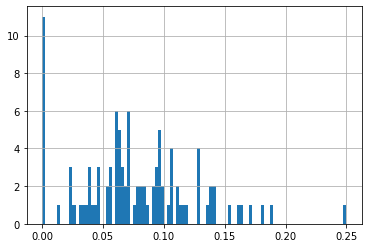

In [41]:
# Ada one shot ROUGE1
newSeries = df_dc_ada_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [45]:
# Babbage one shot
df_dc_babbage_one = dc_one_shot_wrapper(test_DC, training_data=train_DC, test_limit=100, max_tokens=100, strategy="article-summary", engine="babbage")

In [46]:
df_dc_babbage_one.to_csv('df_dc_babbage_one.csv')

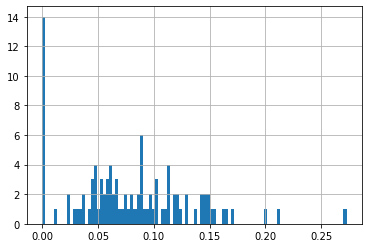

In [47]:
# Babbage one shot ROUGE1
newSeries = df_dc_babbage_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [48]:
# Curie one shot
df_dc_curie_one = dc_one_shot_wrapper(test_DC, training_data=train_DC, test_limit=100, max_tokens=100, strategy="article-summary", engine="curie")

In [49]:
df_dc_curie_one.to_csv('df_dc_curie_one.csv')

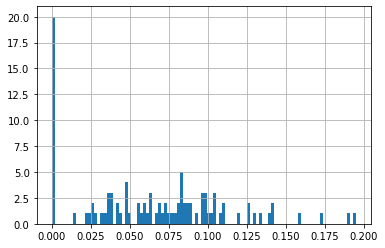

In [50]:
# Curie one shot ROUGE1
newSeries = df_dc_curie_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [42]:
# Davinci one shot
df_dc_davinci_one = dc_one_shot_wrapper(test_DC, training_data=train_DC, test_limit=100, max_tokens=100, strategy="article-summary", engine="davinci")

In [43]:
df_dc_davinci_one.to_csv('df_dc_davinci_one.csv')

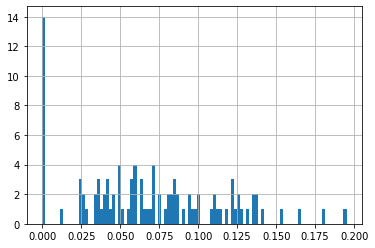

In [44]:
# Davinci one shot ROUGE1
newSeries = df_dc_davinci_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [61]:
# Cumulative one shot ROUGE Scores
ada_one_score_dc = rouge_cumulative(df_dc_ada_one)
babbage_one_score_dc = rouge_cumulative(df_dc_babbage_one)
curie_one_score_dc = rouge_cumulative(df_dc_curie_one)
davinci_one_score_dc = rouge_cumulative(df_dc_davinci_one)

In [62]:
ada_one_score_dc

{'rouge1': AggregateScore(low=Score(precision=0.06485717124967764, recall=0.14876101010896256, fmeasure=0.08716170196704333), mid=Score(precision=0.073392053068218, recall=0.16655811711809065, fmeasure=0.09782620068774213), high=Score(precision=0.08272565992623009, recall=0.1848527403102631, fmeasure=0.10925283666199746)),
 'rouge2': AggregateScore(low=Score(precision=0.001771004258001249, recall=0.004143024588332252, fmeasure=0.0024523529656976257), mid=Score(precision=0.003251836145155949, recall=0.008054272117056702, fmeasure=0.004501225088257955), high=Score(precision=0.004851386798585967, recall=0.013471918104553457, fmeasure=0.006798152335811567)),
 'rougeL': AggregateScore(low=Score(precision=0.04542381941717621, recall=0.10526653382361674, fmeasure=0.061007451040076446), mid=Score(precision=0.05219458552257189, recall=0.11742239746087674, fmeasure=0.0685804552814383), high=Score(precision=0.058947101857647906, recall=0.1305345229508464, fmeasure=0.07519230091399007)),
 'rougeLs

In [64]:
babbage_one_score_dc

{'rouge1': AggregateScore(low=Score(precision=0.06497029906655687, recall=0.1433712168030316, fmeasure=0.08623235957233569), mid=Score(precision=0.07459485170724871, recall=0.16107777594869027, fmeasure=0.0977703098967298), high=Score(precision=0.08448368717480519, recall=0.17751499301022095, fmeasure=0.10811364565879568)),
 'rouge2': AggregateScore(low=Score(precision=0.0014888111505373268, recall=0.003537639263795882, fmeasure=0.002064814919074477), mid=Score(precision=0.002627208168140777, recall=0.00649909496213639, fmeasure=0.003563524162034846), high=Score(precision=0.004076908345696691, recall=0.010521462113488133, fmeasure=0.0054772256292972546)),
 'rougeL': AggregateScore(low=Score(precision=0.04587656578872836, recall=0.10189214917081581, fmeasure=0.061251490483745265), mid=Score(precision=0.05290997148480969, recall=0.11584611073122508, fmeasure=0.06946956364361433), high=Score(precision=0.059659797320665495, recall=0.12804808017733435, fmeasure=0.07741945034881197)),
 'roug

In [63]:
curie_one_score_dc

{'rouge1': AggregateScore(low=Score(precision=0.05362443523399745, recall=0.12095205234017495, fmeasure=0.07224157583847801), mid=Score(precision=0.06235826437496765, recall=0.13926900933334097, fmeasure=0.08383691968755866), high=Score(precision=0.07167506086155184, recall=0.1585546058269513, fmeasure=0.0955565343226556)),
 'rouge2': AggregateScore(low=Score(precision=0.001729227599329458, recall=0.003993539864149914, fmeasure=0.0024078866389191916), mid=Score(precision=0.0029397221560965355, recall=0.0067416380491224625, fmeasure=0.004029886065371807), high=Score(precision=0.004622895725090518, recall=0.010688837004662806, fmeasure=0.00631007353989358)),
 'rougeL': AggregateScore(low=Score(precision=0.03784544958340456, recall=0.08679202492859615, fmeasure=0.051555787183259746), mid=Score(precision=0.04376689496924511, recall=0.10007866188484339, fmeasure=0.05919965124694515), high=Score(precision=0.04947091762029647, recall=0.11309875134148469, fmeasure=0.06674760767055118)),
 'roug

In [65]:
davinci_one_score_dc

{'rouge1': AggregateScore(low=Score(precision=0.05767966016531869, recall=0.13367562580210016, fmeasure=0.07874261972328889), mid=Score(precision=0.06613154714003922, recall=0.15384101391501995, fmeasure=0.09048739930837386), high=Score(precision=0.07477379323747425, recall=0.17258327158584896, fmeasure=0.10182919533588679)),
 'rouge2': AggregateScore(low=Score(precision=0.0018491976249591193, recall=0.004343407656440121, fmeasure=0.0025679246259008052), mid=Score(precision=0.0031522787014475937, recall=0.007821936991171952, fmeasure=0.0044135654523807626), high=Score(precision=0.004924454378905914, recall=0.012157052774360565, fmeasure=0.006869981738087216)),
 'rougeL': AggregateScore(low=Score(precision=0.04161943963341578, recall=0.09769795497313713, fmeasure=0.05708763947695959), mid=Score(precision=0.04715959052703302, recall=0.11072235888735876, fmeasure=0.06456841290083028), high=Score(precision=0.052408769891911226, recall=0.12427735682825095, fmeasure=0.07180314095225059)),
 '

## Tests (Gigaword)

### Testing Different Engines

OpenAI comes with four different engines: `ada`, `babbage`, `curie`, `davinci`

We export the results of `davinci` for human testing
```
article: ...
summary: ...
###
article: ...
summary: ...
###
...
###
article: ...
summary:
```
I graph the ROUGE1 score for each of these tests. Although the mean of each test is low relative to the SOTA, you can see the performance improve a bit as we use better engines and more significantly as we go from zero to one to few shot variants. The few shot (10) davinci engine is by far the best. Each of the test results has been exported to a csv file.



In [ ]:
# Ada few shot 5 instances
df_gw_ada_few = gw_few_shot_wrapper(test_GW, training_data=train_GW, test_limit=200, training_instances=5, strategy="article-summary", engine="ada")

In [ ]:
df_gw_ada_few.to_csv('df_gw_ada_few.csv')

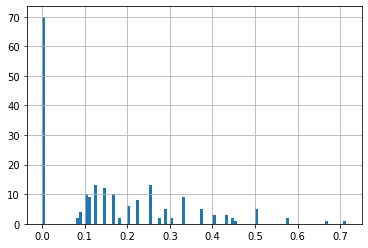

In [ ]:
# Ada few shot ROUGE1
newSeries = df_gw_ada_few["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Ada few shot 10 instances
df_gw_ada_few_ten = gw_few_shot_wrapper(test_GW, training_data=train_GW, test_limit=200, training_instances=10, strategy="article-summary", engine="ada")

In [ ]:
df_gw_ada_few_ten.to_csv('df_gw_ada_few_ten.csv')

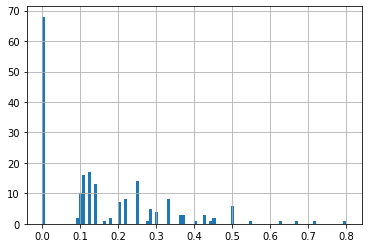

In [ ]:
# Ada few shot ROUGE1
newSeries = df_gw_ada_few_ten["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Babbage
df_gw_babbage_zero = gw_wrapper(test_GW, test_limit=500, strategy="article-summary", engine="babbage")

In [ ]:
df_gw_babbage_zero.to_csv('df_gw_babbage_zero.csv')

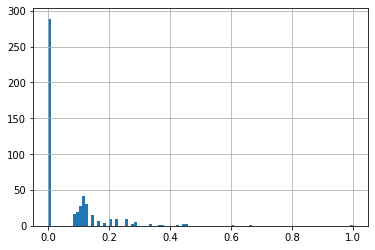

In [ ]:
# Babbage zero shot ROUGE1
newSeries = df_gw_babbage_zero["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Babbage one shot
df_gw_babbage_one = gw_one_shot_wrapper(test_GW, training_data=train_GW, test_limit=500, strategy="article-summary", engine="babbage")

In [ ]:
df_gw_babbage_one.to_csv('df_gw_babbage_one.csv')

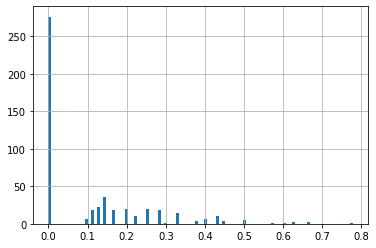

In [ ]:
# Babbage one shot ROUGE1
newSeries = df_gw_babbage_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Babbage few shot 10 instances
df_gw_babbage_few_ten = gw_few_shot_wrapper(test_GW, training_data=train_GW, test_limit=200, training_instances=10, strategy="article-summary", engine="babbage")

In [ ]:
df_gw_babbage_few_ten.to_csv('df_gw_babbage_few_ten.csv')

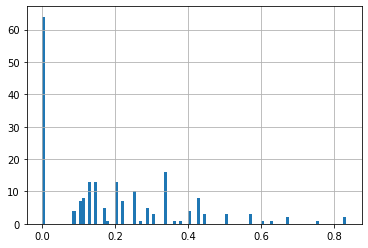

In [ ]:
# Babbage few shot ROUGE1
newSeries = df_gw_babbage_few_ten["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Curie zero shot
df_gw_curie_zero = gw_wrapper(test_GW, test_limit=500, strategy="article-summary", engine="curie")

In [ ]:
df_gw_curie_zero.to_csv('df_gw_curie_zero.csv')

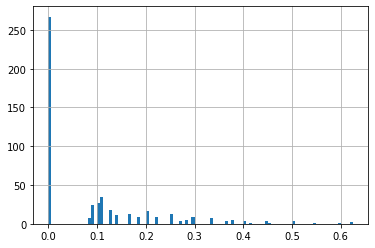

In [ ]:
# Curie zero shot ROUGE1
newSeries = df_gw_curie_zero["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Curie one shot
df_gw_curie_one = gw_one_shot_wrapper(test_GW, training_data=train_GW, test_limit=500, strategy="article-summary", engine="curie")

In [ ]:
df_gw_curie_one.to_csv('df_gw_curie_one.csv')

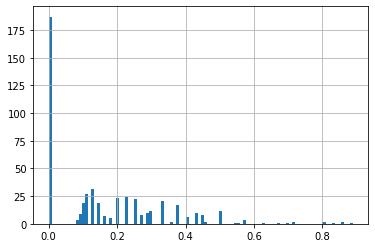

In [ ]:
# Curie one shot ROUGE1
newSeries = df_gw_curie_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Curie few shot 10 instances
df_gw_curie_few_ten = gw_few_shot_wrapper(test_GW, training_data=train_GW, test_limit=200, training_instances=10, strategy="article-summary", engine="curie")

In [ ]:
df_gw_curie_few_ten.to_csv('df_gw_curie_few_ten.csv')

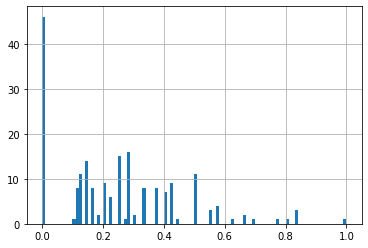

In [ ]:
# Curie few shot ROUGE1
newSeries = df_gw_curie_few_ten["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Davinci
df_gw_davinci_zero = gw_wrapper(test_GW, test_limit=500, strategy="article-summary", engine="davinci")

In [ ]:
df_gw_davinci_zero.to_csv('df_gw_davinci_zero.csv')

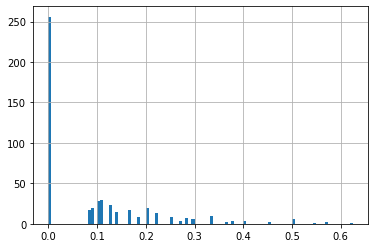

In [ ]:
# Davinci zero shot ROUGE1
newSeries = df_gw_davinci_zero["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Davinci one shot
df_gw_davinci_one = gw_one_shot_wrapper(test_GW, training_data=train_GW, test_limit=200, strategy="article-summary", engine="davinci")

In [ ]:
df_gw_davinci_one.to_csv('df_gw_davinci_one.csv')

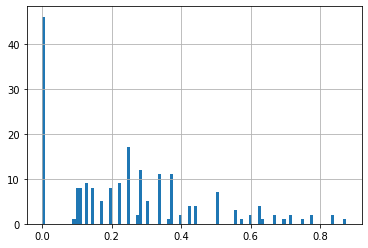

In [ ]:
# Davinci one shot ROUGE1
newSeries = df_gw_davinci_one["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Davinci few shot 10 instances
df_gw_davinci_few_ten = gw_few_shot_wrapper(test_GW, training_data=train_GW, test_limit=100, training_instances=10, strategy="article-summary", engine="davinci")

In [ ]:
df_gw_davinci_few_ten.to_csv('df_gw_davinci_few_ten.csv')

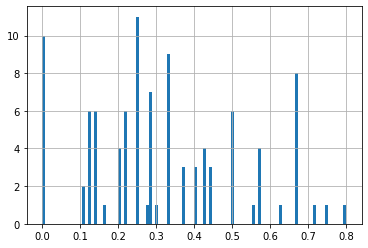

In [ ]:
# Davinci few shot ROUGE1
newSeries = df_gw_davinci_few_ten["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

In [ ]:
# Cumulative Zero shot ROUGE Scores
ada_zero_score = rouge_cumulative(df_gw_article_summary_zero)
curie_zero_score = rouge_cumulative(df_gw_curie_zero)
babbage_zero_score = rouge_cumulative(df_gw_babbage_zero)
davinci_zero_score = rouge_cumulative(df_gw_davinci_zero)

In [ ]:
ada_zero_score

{'rouge1': AggregateScore(low=Score(precision=0.05055442099567098, recall=0.05777453571755036, fmeasure=0.05278939914422178), mid=Score(precision=0.057819841269841285, recall=0.0669763277572101, fmeasure=0.06017711932018356), high=Score(precision=0.06609862914862917, recall=0.07743038697413697, fmeasure=0.06905659577219009)),
 'rouge2': AggregateScore(low=Score(precision=0.006584608585858586, recall=0.008250674603174602, fmeasure=0.007033514535990475), mid=Score(precision=0.009475793650793648, recall=0.012030555555555556, fmeasure=0.010068626860792696), high=Score(precision=0.01302294191919192, recall=0.016682261904761905, fmeasure=0.013684664888233172)),
 'rougeL': AggregateScore(low=Score(precision=0.04684162698412696, recall=0.053467618590559735, fmeasure=0.048697100405914365), mid=Score(precision=0.053808982683982674, recall=0.06175841348194283, fmeasure=0.05579831965447585), high=Score(precision=0.06068726190476188, recall=0.07060361237618591, fmeasure=0.06322205568224784)),
 'rou

In [ ]:
babbage_zero_score

{'rouge1': AggregateScore(low=Score(precision=0.05144087662337656, recall=0.052907142199905326, fmeasure=0.05018678999754904), mid=Score(precision=0.0599900793650793, recall=0.06092627672035565, fmeasure=0.0577829926847796), high=Score(precision=0.06948191738816735, recall=0.07012567912350808, fmeasure=0.06581428091927992)),
 'rouge2': AggregateScore(low=Score(precision=0.004272126623376625, recall=0.004189543650793652, fmeasure=0.004138676715011857), mid=Score(precision=0.007532287157287158, recall=0.007929761904761905, fmeasure=0.007275846521899153), high=Score(precision=0.011857067099567097, recall=0.012206587301587295, fmeasure=0.011171252599739442)),
 'rougeL': AggregateScore(low=Score(precision=0.05014161976911976, recall=0.05152847565081115, fmeasure=0.048573102708471295), mid=Score(precision=0.05797406204906202, recall=0.05955321783479674, fmeasure=0.056027498343129783), high=Score(precision=0.0664552525252525, recall=0.06795682065376146, fmeasure=0.06364030843255294)),
 'rouge

In [ ]:
curie_zero_score

{'rouge1': AggregateScore(low=Score(precision=0.07108848484848485, recall=0.07514267977120921, fmeasure=0.07120701744589719), mid=Score(precision=0.08122178932178943, recall=0.08597937283304938, fmeasure=0.08083762369468718), high=Score(precision=0.09175841269841291, recall=0.09678504703629716, fmeasure=0.09100462171539819)),
 'rouge2': AggregateScore(low=Score(precision=0.011616080447330448, recall=0.011948939255189257, fmeasure=0.011476008555857632), mid=Score(precision=0.016492965367965365, recall=0.017304034854034853, fmeasure=0.016238175532757575), high=Score(precision=0.02141954545454544, recall=0.022720699161949152, fmeasure=0.021229738769572355)),
 'rougeL': AggregateScore(low=Score(precision=0.06545416847041843, recall=0.06888901496379436, fmeasure=0.06521650919425508), mid=Score(precision=0.07444080086580093, recall=0.07905108625035098, fmeasure=0.0743632754405274), high=Score(precision=0.08417875541125548, recall=0.09018289651933042, fmeasure=0.08437810080108736)),
 'rougeLs

In [ ]:
davinci_zero_score

{'rouge1': AggregateScore(low=Score(precision=0.07046140151515154, recall=0.07402715275522553, fmeasure=0.07035532042449946), mid=Score(precision=0.0791329725829726, recall=0.08437807214715123, fmeasure=0.07911977536870185), high=Score(precision=0.08964501082251093, recall=0.09618297566146454, fmeasure=0.0898863135804315)),
 'rouge2': AggregateScore(low=Score(precision=0.007398612914862917, recall=0.008100399531024531, fmeasure=0.007657672945333633), mid=Score(precision=0.010683766233766231, recall=0.011980801143301143, fmeasure=0.011017854029928338), high=Score(precision=0.014947065295815283, recall=0.016888314393939393, fmeasure=0.015302127029466848)),
 'rougeL': AggregateScore(low=Score(precision=0.06519479797979798, recall=0.06856140683104309, fmeasure=0.0649405045402948), mid=Score(precision=0.07404047619047624, recall=0.07834565998586904, fmeasure=0.07378408825855262), high=Score(precision=0.08367593434343441, recall=0.08932911731822547, fmeasure=0.08310757108754101)),
 'rougeLsu

In [ ]:
# Cumulative One shot ROUGE Scores
ada_one_score = rouge_cumulative(df_gw_article_summary_one_shot_ada)
curie_one_score = rouge_cumulative(df_gw_curie_one)
babbage_one_score = rouge_cumulative(df_gw_babbage_one)
davinci_one_score = rouge_cumulative(df_gw_davinci_one)

In [ ]:
ada_one_score

{'rouge1': AggregateScore(low=Score(precision=0.07121676587301586, recall=0.05970950527177498, fmeasure=0.06284019584388771), mid=Score(precision=0.08085555555555556, recall=0.0679577575932839, fmeasure=0.07140692832067845), high=Score(precision=0.09162132936507945, recall=0.07736218899521538, fmeasure=0.08115584491708043)),
 'rouge2': AggregateScore(low=Score(precision=0.008232499999999997, recall=0.007111371961371961, fmeasure=0.007358972189661046), mid=Score(precision=0.012339285714285716, recall=0.010724264624264623, fmeasure=0.011059780862412442), high=Score(precision=0.016959702380952388, recall=0.014830548756798753, fmeasure=0.014980747144582284)),
 'rougeL': AggregateScore(low=Score(precision=0.06797720238095238, recall=0.05735169056090107, fmeasure=0.05996410121463336), mid=Score(precision=0.07770039682539687, recall=0.06547860582400056, fmeasure=0.06869956075218554), high=Score(precision=0.08727595238095247, recall=0.07415567921844235, fmeasure=0.07719939162257104)),
 'rougeL

In [ ]:
babbage_one_score

{'rouge1': AggregateScore(low=Score(precision=0.08591658730158738, recall=0.07172636679475497, fmeasure=0.07566322787621745), mid=Score(precision=0.09712936507936516, recall=0.0819492341378952, fmeasure=0.08592352725962499), high=Score(precision=0.10887765873015885, recall=0.09336297112201543, fmeasure=0.09694370509441792)),
 'rouge2': AggregateScore(low=Score(precision=0.014440119047619056, recall=0.011894063159063165, fmeasure=0.012571391981771238), mid=Score(precision=0.020522619047619046, recall=0.017510260295260295, fmeasure=0.018228672280924355), high=Score(precision=0.026758749999999987, recall=0.023441224386724382, fmeasure=0.02404074913451672)),
 'rougeL': AggregateScore(low=Score(precision=0.07933333333333335, recall=0.0666396071839667, fmeasure=0.07012005317566722), mid=Score(precision=0.09075555555555562, recall=0.07665272827447751, fmeasure=0.08033736907327221), high=Score(precision=0.10326676587301602, recall=0.08778573222615033, fmeasure=0.09078310757090048)),
 'rougeLsu

In [ ]:
curie_one_score

{'rouge1': AggregateScore(low=Score(precision=0.13185628427128443, recall=0.13364565381599847, fmeasure=0.12919825394997533), mid=Score(precision=0.14520826118326133, recall=0.14938301944873172, fmeasure=0.1427753030096029), high=Score(precision=0.15980161075036087, recall=0.16521195385368015, fmeasure=0.15644049270899074)),
 'rouge2': AggregateScore(low=Score(precision=0.03017417027417027, recall=0.03186492153679653, fmeasure=0.029405099652277094), mid=Score(precision=0.03831998556998554, recall=0.04073250777000775, fmeasure=0.03751272381131378), high=Score(precision=0.047204825036075, recall=0.05090641774891776, fmeasure=0.04641077751620133)),
 'rougeL': AggregateScore(low=Score(precision=0.12095389790764813, recall=0.12433847445725953, fmeasure=0.11894174964516363), mid=Score(precision=0.13480533910533937, recall=0.13895446548635426, fmeasure=0.13223908220218308), high=Score(precision=0.14835092532467548, recall=0.154038261074581, fmeasure=0.14543182953807154)),
 'rougeLsum': Aggreg

In [ ]:
davinci_one_score

{'rouge1': AggregateScore(low=Score(precision=0.19439288870851373, recall=0.1677177239513152, fmeasure=0.17371028962296609), mid=Score(precision=0.22284072871572874, recall=0.19496426575015974, fmeasure=0.200703678198568), high=Score(precision=0.25246266684704183, recall=0.22239739396095826, fmeasure=0.22827639990505974)),
 'rouge2': AggregateScore(low=Score(precision=0.04066929563492064, recall=0.03572181422743924, fmeasure=0.03649509216493376), mid=Score(precision=0.05784027777777776, recall=0.05080100316350317, fmeasure=0.052177746335901845), high=Score(precision=0.0766893353174603, recall=0.06957724254911753, fmeasure=0.07024675097915312)),
 'rougeL': AggregateScore(low=Score(precision=0.1720338338744588, recall=0.15072868016379035, fmeasure=0.1548811855644093), mid=Score(precision=0.19754942279942284, recall=0.17454578466768872, fmeasure=0.17856038580386563), high=Score(precision=0.22262226280663788, recall=0.20088108283400474, fmeasure=0.20394364700973505)),
 'rougeLsum': Aggrega

In [ ]:
# Cumulative Few shot ROUGE Scores
ada_few_score = rouge_cumulative(df_gw_ada_few_ten)
babbage_few_score = rouge_cumulative(df_gw_babbage_few_ten)
curie_few_score = rouge_cumulative(df_gw_curie_few_ten)
davinci_few_score = rouge_cumulative(df_gw_davinci_few_ten)

In [ ]:
ada_few_score

{'rouge1': AggregateScore(low=Score(precision=0.12307162247474736, recall=0.11253786188441754, fmeasure=0.1132908461208422), mid=Score(precision=0.14307404401154394, recall=0.13245580561079784, fmeasure=0.1323298280270752), high=Score(precision=0.16409520652958148, recall=0.1541635104258701, fmeasure=0.15283062992754418)),
 'rouge2': AggregateScore(low=Score(precision=0.01762042297979798, recall=0.016077100503663008, fmeasure=0.016147832598258294), mid=Score(precision=0.027093434343434343, recall=0.024734650765900763, fmeasure=0.02472160697489645), high=Score(precision=0.037608603896103904, recall=0.03452229662698412, fmeasure=0.03428302581598827)),
 'rougeL': AggregateScore(low=Score(precision=0.11758951118326114, recall=0.107500686420133, fmeasure=0.10845911373926914), mid=Score(precision=0.1354675324675324, recall=0.12569458490211194, fmeasure=0.1255651993212885), high=Score(precision=0.15536737012987, recall=0.1448856000509637, fmeasure=0.14322046514996)),
 'rougeLsum': AggregateSc

In [ ]:
babbage_few_score

{'rouge1': AggregateScore(low=Score(precision=0.14086556637806627, recall=0.11905997598140587, fmeasure=0.1245779497661681), mid=Score(precision=0.16484045815295806, recall=0.13934128174027546, fmeasure=0.1446637404267127), high=Score(precision=0.1878315340909091, recall=0.1582059409942051, fmeasure=0.16268445268132667)),
 'rouge2': AggregateScore(low=Score(precision=0.023486507936507937, recall=0.0194477773962149, fmeasure=0.020490474618821305), mid=Score(precision=0.03464484126984126, recall=0.029421176046176042, fmeasure=0.03030284849533739), high=Score(precision=0.04798814484126984, recall=0.04087589198995449, fmeasure=0.041798802779420954)),
 'rougeL': AggregateScore(low=Score(precision=0.13510006313131306, recall=0.11379035778785185, fmeasure=0.11880018429053156), mid=Score(precision=0.15669805194805186, recall=0.13169370165867844, fmeasure=0.1371050692180173), high=Score(precision=0.18074550414862917, recall=0.15295854343884524, fmeasure=0.15688258200582153)),
 'rougeLsum': Aggr

In [ ]:
curie_few_score

{'rouge1': AggregateScore(low=Score(precision=0.18327499098124095, recall=0.15051876204559536, fmeasure=0.15942112424331606), mid=Score(precision=0.2102632575757576, recall=0.17443094258467706, fmeasure=0.18339826032523904), high=Score(precision=0.23830612824675343, recall=0.19962779295760144, fmeasure=0.2084747897465015)),
 'rouge2': AggregateScore(low=Score(precision=0.04008288690476191, recall=0.03270491439116438, fmeasure=0.034332870833105385), mid=Score(precision=0.055795634920634905, recall=0.04650333832833832, fmeasure=0.04767429029444748), high=Score(precision=0.07147445436507933, recall=0.06099285589410587, fmeasure=0.06172846030856678)),
 'rougeL': AggregateScore(low=Score(precision=0.1638027462121211, recall=0.1336057611742402, fmeasure=0.14203236667003236), mid=Score(precision=0.18819200937950936, recall=0.15566200733605912, fmeasure=0.1638867914537347), high=Score(precision=0.21269971590909093, recall=0.17694707507082696, fmeasure=0.18514519893467732)),
 'rougeLsum': Aggre

In [ ]:
davinci_few_score

{'rouge1': AggregateScore(low=Score(precision=0.25499090007215, recall=0.2183917628574555, fmeasure=0.2282136193696111), mid=Score(precision=0.2948735569985569, recall=0.2580829826348402, fmeasure=0.2663181623319023), high=Score(precision=0.33253313492063485, recall=0.29525753876111843, fmeasure=0.3037840587085624)),
 'rouge2': AggregateScore(low=Score(precision=0.06166061507936509, recall=0.05498129786879787, fmeasure=0.05707867303190444), mid=Score(precision=0.08658531746031747, recall=0.07893020868020868, fmeasure=0.08083974191443231), high=Score(precision=0.1140650793650793, recall=0.10696925713175709, fmeasure=0.10813547077707288)),
 'rougeL': AggregateScore(low=Score(precision=0.23555386904761894, recall=0.20261759643650118, fmeasure=0.21168444357395483), mid=Score(precision=0.26755591630591613, recall=0.23495960405693372, fmeasure=0.24217246504635787), high=Score(precision=0.305259226190476, recall=0.2719808262858573, fmeasure=0.2792343796999018)),
 'rougeLsum': AggregateScore(l

### Testing Different Strategies

OpenAI gives examples in which you suffix your text with `tl;dr:`, `One-sentence summary:`, and `I rephrased this for my daughter, in plain language a second grader can understand:` to induce summarization

We compare the ROUGE scores of these and a few more strategies.

These tests are done using `ada` as this most preserves token use.

We didn't find much of a difference between postfixing inputs with "tl;dr:" and using "article:... summary:"

We also check qualitatively whether GPT can respond flexibly for demands of more/less abstractive/extractive summaries, and correctly interpret parameters like word count, sentence count

The latter few tests are postfixing inputs with "one sentence summary:" and "two sentence summary:" to see if this induces any different behavior by the model. I graph the number of sentences spit out by the model for these tests to see. I do the same for words. 

**TL:DR;**

In [ ]:
# tldr ada zero-shot
df_gw_tldr = gw_wrapper(test_GW, test_limit=500, strategy="tldr", engine="ada")

In [ ]:
# export
df_gw_tldr.to_csv('df_gw_tldr.csv')

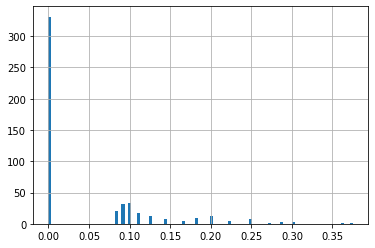

In [ ]:
# tldr ROUGE1
newSeries = df_gw_tldr["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

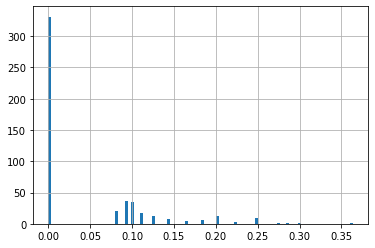

In [ ]:
# tldr ROUGEL
newSeries = df_gw_tldr["score"].apply(lambda x: x['rougeL'][1])
newSeries.hist(bins=100)

In [ ]:
# TLDR One-shot Ada
df_gw_tldr_one_shot_ada = gw_one_shot_wrapper(test_GW, training_data=train_GW, test_limit=500, engine="ada", strategy="tldr")

In [ ]:
df_gw_tldr_one_shot_ada.to_csv('df_gw_tldr_one_shot_ada.csv')

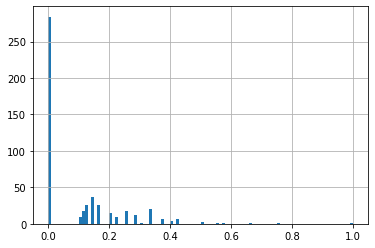

In [ ]:
# tldr one shot ROUGE1
newSeries = df_gw_tldr_one_shot_ada["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

**Article: Summary:**

In [ ]:
# article-summary zero shot
df_gw_article_summary_zero = gw_wrapper(test_GW, test_limit=500, strategy="article-summary", engine="ada")

In [ ]:
# Export davinci as csv
df_gw_article_summary_zero.to_csv('df_gw_article_summary_zero.csv')

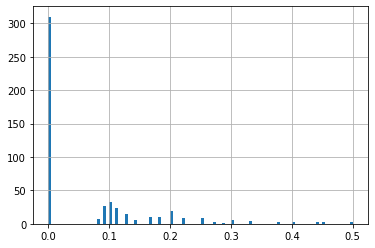

In [ ]:
# article: summary: ROUGE1
newSeries = df_gw_article_summary_zero["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

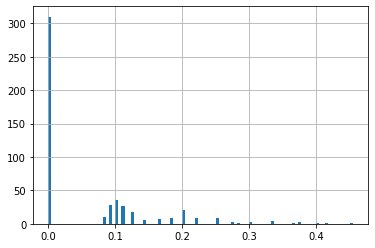

In [ ]:
# article: summary: ROUGE1
newSeries = df_gw_article_summary_zero["score"].apply(lambda x: x['rougeL'][1])
newSeries.hist(bins=100)

In [ ]:
# article: summary: One-shot Ada
df_gw_article_summary_one_shot_ada = gw_one_shot_wrapper(test_GW, training_data=train_GW, test_limit=500, engine="ada", strategy="article-summary")

In [ ]:
df_gw_article_summary_one_shot_ada.to_csv('df_gw_article_summary_one_shot_ada.csv')

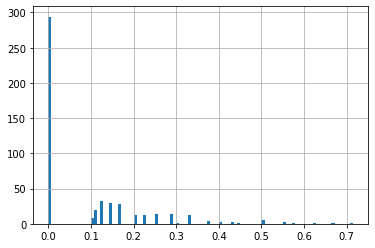

In [ ]:
# article: summary: ROUGE1
newSeries = df_gw_article_summary_one_shot_ada["score"].apply(lambda x: x['rouge1'][1])
newSeries.hist(bins=100)

**Controlling sentence count**

In [ ]:
# (One, Two) sentence zero-shot summary
df_gw_one_sentence_zero = gw_wrapper(test_GW, test_limit=500, max_tokens=32,strategy="custom", engine="ada", customStrategy=(lambda input: input + "\n\nOne sentence summary:"))

In [ ]:
df_gw_one_sentence_zero.to_csv('df_gw_one_sentence_zero.csv')

In [ ]:
df_gw_two_sentence_zero = gw_wrapper(test_GW, test_limit=500, max_tokens=32, strategy="custom", engine="ada", customStrategy=(lambda input: input + "\n\nTwo sentence summary:"))

In [ ]:
df_gw_two_sentence_zero.to_csv('df_gw_two_sentence_zero.csv')

In [ ]:
df_gw_numbertwo_sentence_zero = gw_wrapper(test_GW, test_limit=500, max_tokens=32, strategy="custom", engine="ada", customStrategy=(lambda input: input + "\n\n2 sentence summary:"))

In [ ]:
df_gw_numbertwo_sentence_zero.to_csv('df_gw_numbertwo_sentence_zero.csv')

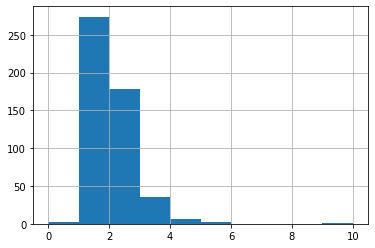

In [ ]:
# How many sentences is each response?
newSeries = df_gw_one_sentence_zero["predictions"].apply(lambda x: len(tokenize.sent_tokenize(x)))
newSeries.hist()

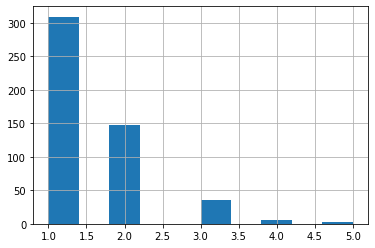

In [ ]:
newSeries = df_gw_two_sentence_zero["predictions"].apply(lambda x: len(tokenize.sent_tokenize(x)))
newSeries.hist()

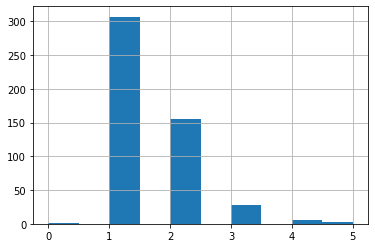

In [ ]:
newSeries = df_gw_numbertwo_sentence_zero["predictions"].apply(lambda x: len(tokenize.sent_tokenize(x)))
newSeries.hist()

**Controlling word count**

In [ ]:
# X word summary
df_gw_five_word_zero = gw_wrapper(test_GW, test_limit=500, max_tokens=32,strategy="custom", engine="ada", customStrategy=(lambda input: input + "\n\nFive word summary:"))

In [ ]:
df_gw_five_word_zero.to_csv('df_gw_five_word_zero.csv')

In [ ]:
df_gw_ten_word_zero = gw_wrapper(test_GW, test_limit=500, max_tokens=32,strategy="custom", engine="ada", customStrategy=(lambda input: input + "\n\nTen word summary:"))

In [ ]:
df_gw_ten_word_zero.to_csv('df_gw_ten_word_zero.csv')

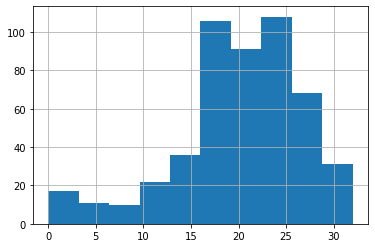

In [ ]:
# How many words is each response?
newSeries = df_gw_five_word_zero["predictions"].apply(lambda x: len(x.split()))
newSeries.hist()

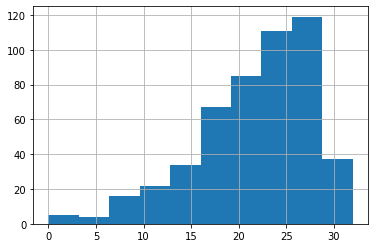

In [ ]:
newSeries = df_gw_ten_word_zero["predictions"].apply(lambda x: len(x.split()))
newSeries.hist()

In [ ]:
# Cumulative ROUGE Scores
# Table
rouge_cumulative(df_gw_tldr)
rouge_cumulative(df_gw_article_summary)
scores = []
df = pd.DataFrame(d, columns=["ROUGE1", "ROUGEL"])

We also compares the scores for the zero-shot and one-shot variants of some of these strategies. In the one-shot variant, we add to the input an example of an article, summary pair.